# TFM - Cristian Leguisamon - Universidad Castilla-La Mancha 
## Master en ciencia de datos e ingeniería de datos en la nube
### TFM - Parte 02

Carga de módulos, librerias y configuraciones

In [97]:
!pip install pulp
!pip install openai
import json
import pandas as pd
import openai
from collections import defaultdict
from pulp import LpProblem, LpMaximize, LpVariable, lpSum, LpStatus
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.exceptions import ConvergenceWarning
import numpy as np
import copy
import warnings
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

OPEN_AI_KEY=''
OPEN_AI_ORG='org-w13PnAMq4ebjDxHSqcRxrB9c'
GPT_ENGINE='text-davinci-003'
openai.organization = OPEN_AI_ORG
openai.api_key = OPEN_AI_KEY
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.filterwarnings("ignore", category=UserWarning, message="X does not have valid feature names")
complete_data_folder = "Full_Dataset"

Cargamos los datos previamente preparados en el notebook anterior. Por un lado tenemos los datos de los usuarios de las pulseras FitBit y por otro, un dataset de alimentos con su correspondiente detalle nutricional

In [98]:
df_user_data = pd.read_csv(f"{complete_data_folder}/df_user_data.csv")
df_nutrition= pd.read_csv(f"{complete_data_folder}/df_nutrition.csv")
df_nutrition.fillna(0, inplace=True)
df_nutrition = df_nutrition.drop_duplicates(subset=['name'])

with open(f"{complete_data_folder}/nutrition_structure.json", 'r') as json_file:
    nutrition_structure = json.load(json_file)
with open(f"{complete_data_folder}/nutrition_equations.json", 'r') as json_file:
    nutrition_equations = json.load(json_file)

Definimos la Funcion nutrition_settings. Sirve para calcular la cantidad de nutrientes necesarios para un individuo, para cada comida (desayuno, almuerzo, merienda y cena), en funcion del tipo de comida, su edad, actividad, peso y calorias consumidas previamente.
Esto se calcula, utilizando como parametro el json nutrition_structure. Basicamente, este json es un diccionario de ecuaciones. Por ejemplo, para cada desayuno se requiere una X cantidad de proteinas, una X cantidad de azucar, etc. Algunas variables están en funcion del peso, del consumo calórico y el nivel de actividad.
La estimación de estas ecuaciones, surge de distintas fuentes y no hay un parametro fijo. De hecho, los nutrientes necesarios para cada persona dependen de muchisimos factores y no solo de los indicados en este trabajo.

In [99]:
def nutrition_settings(filtered_rows,nutrition_structure):
    nutrition_structure_copy = copy.deepcopy(nutrition_structure)
    meals = ['breakfast','lunch','snack','dinner']
    weight = filtered_rows['WeightKg'].iloc[0]
    calories = filtered_rows['Calories'].iloc[0]
    avg_activity = filtered_rows['avg_activity'].iloc[0]
    if int(filtered_rows['age'].iloc[0]) > 59:
        age_factor = 0.8
    else:
        age_factor = 1
        
    for meal in meals:
        for nutrient, equation in nutrition_equations.get(meal).items():
            calculated_value = eval(equation, {'calories': calories, 'weight': weight, 'age_factor': age_factor, 'avg_activity': avg_activity})
            nutrition_structure_copy[meal][nutrient]['amount'] = round(calculated_value,2)
    return nutrition_structure_copy

Creamos un dataset que permite conocer, para cada individuo, la cantidad de nutrientes que debería ingerir en cada comida, considerando los datos disponibles respecto de sus caracteristicas personales.

In [100]:
unique_ids = df_user_data['Id'].unique()
nutrition_results = {}
for id_value in unique_ids:
    filtered_rows = df_user_data.loc[df_user_data['Id'] == id_value]
    result = nutrition_settings(filtered_rows, nutrition_structure)
    nutrition_results[id_value] = result

In [101]:
rows = []
for user_id, meals in nutrition_results.items():
    for meal, nutrients in meals.items():
        row = {'Id': user_id, 'Meal': meal}
        for nutrient, values in nutrients.items():
            row[nutrient +'_meal'] = values['amount']
        rows.append(row)

df_estimations = pd.DataFrame(rows)
df_estimations.head(5)

,Id,Meal,Calories_meal,Proteins_meal,Carbohydrates_meal,Fats_meal,Fiber_meal,Sugar_meal,Calcium_meal,Vitamin C_meal
0,1503960366,breakfast,496.25,5.75,11.51,2.56,25,25,500,70.0
1,1503960366,lunch,694.75,6.90,9.20,3.07,25,25,500,52.5
2,1503960366,snack,297.75,5.75,11.51,2.56,25,25,300,70.0
3,1503960366,dinner,496.25,5.75,11.51,2.56,25,25,500,70.0
4,1624580081,breakfast,358.00,6.49,12.98,2.88,25,25,500,44.8


Para tener un backup de los datos, los guardamos en el siguiente fichero

In [50]:
df_estimations.to_csv(f"{complete_data_folder}/df_estimations.csv", index=False)

A continuación, creamos un df alternativo con las variables necesarias sobre el usuario

In [102]:
user_info_selected = df_user_data.loc[:, ['Id', 'age','avg_activity','WeightKg','BMI','Height','Calories']]
df_combined = df_estimations.merge(user_info_selected, on='Id')
columns_to_convert = ['Calories_meal', 'Proteins_meal', 'Carbohydrates_meal', 'Fats_meal', 'Fiber_meal',
                      'Sugar_meal', 'Calcium_meal', 'Vitamin C_meal', 'age', 'avg_activity', 'WeightKg',
                      'BMI', 'Height', 'Calories']
df_combined[columns_to_convert] = df_combined[columns_to_convert].apply(pd.to_numeric, errors='coerce')
df_combined.fillna(0, inplace=True)
print(df_combined.head(5))

           Id       Meal  Calories_meal  Proteins_meal  Carbohydrates_meal  \
0  1503960366  breakfast         496.25           5.75               11.51   
1  1503960366      lunch         694.75           6.90                9.20   
2  1503960366      snack         297.75           5.75               11.51   
3  1503960366     dinner         496.25           5.75               11.51   
4  1624580081  breakfast         358.00           6.49               12.98   

   Fats_meal  Fiber_meal  Sugar_meal  Calcium_meal  Vitamin C_meal  age  \
0       2.56          25          25           500            70.0   35   
1       3.07          25          25           500            52.5   35   
2       2.56          25          25           300            70.0   35   
3       2.56          25          25           500            70.0   35   
4       2.88          25          25           500            44.8   35   

   avg_activity   WeightKg    BMI  Height  Calories  
0          1.75  52.599443

Antes de continuar, consultamos los datos para un usuario especifico y calculamos los valores nutricionales necesarios (que actuarán como valores límites). Estos valores son importantes para la estimacion de la mejor cesta de consumo de alimentos.

In [103]:
id_search = 1503960366
filtered_rows = df_user_data.loc[df_user_data['Id'] == id_search]
nutrition_structure = nutrition_settings(filtered_rows,nutrition_structure)

In [104]:
id_list = []
moment_list = []
calories_list = []
proteins_list = []
carbs_list = []
fats_list = []
fiber_list = []
sugar_list = []

for moment, values in nutrition_structure.items():
    id_list.append(id_search)
    moment_list.append(moment)
    calories_list.append(values['Calories']['amount'])
    proteins_list.append(values['Proteins']['amount'])
    carbs_list.append(values['Carbohydrates']['amount'])
    fats_list.append(values['Fats']['amount'])
    fiber_list.append(values['Fiber']['amount'])
    sugar_list.append(values['Sugar']['amount'])

# Create a DataFrame
df_user_sample = pd.DataFrame({
    'Id': id_list,
    'Moment': moment_list,
    'Calories': calories_list,
    'Proteins': proteins_list,
    'Carbohydrates': carbs_list,
    'Fats': fats_list,
    'Fiber': fiber_list,
    'Sugar': sugar_list
})

print(df_user_sample)

           Id     Moment  Calories  Proteins  Carbohydrates  Fats  Fiber  \
0  1503960366  breakfast    496.25      5.75          11.51  2.56     25   
1  1503960366      lunch    694.75      6.90           9.20  3.07     25   
2  1503960366      snack    297.75      5.75          11.51  2.56     25   
3  1503960366     dinner    496.25      5.75          11.51  2.56     25   

   Sugar  
0     25  
1     25  
2     25  
3     25  


Para un tipo de comida (breakfast, dinner, etc), obtenemos la cantidad de nutrientes y vitaminas que la persona debería ingerir, considerando sus caracteristicas personales.

In [105]:
def get_constraints(nutrition_structure,meal):
    return nutrition_structure.get(meal)

In [106]:
def get_list_from_openai(food_list, meal):
    PROMPT_NEW_TEXT = f"Use this list to create another one, only with meals that can be used, in general, for {meal}. Do not add any aditional meal. Your answer must be a list comma separated and nothing else. Do not add any text before or after your answer. The base list is {food_list}"
    response_body = openai.Completion.create(
    engine=GPT_ENGINE, prompt=PROMPT_NEW_TEXT, temperature=0.5, max_tokens=1500
    )
    food_list = response_body["choices"][0]["text"]
    food_list = food_list.strip().rstrip('.').split(', ')
    return food_list

Del listado de alimentos seleccionamos aquellos que, en términos generales, suelen ser utilizados en cada comida (breakfast, lunch, etc.) Para esto, utilizamos la librería de OpenAI. Está pensado de esta manera porque distintos tipos de alimentos pueden ser utilizados en mas de una ocasion. Ademas, el dataset en este caso es limitado. Si tuvieramos un dataset mucho mas grande y con mayor detalle de su valor nutricional, la estructura del dataset deberia ser otra y no podría calcularse de modo eficiente. Pero en este caso, cada vez que es necesario, consultamos a ChatGPT cuales de los alimentos podria ser utilizado en cada momento del dia.

In [107]:
def first_recommendations(df_nutrition, meal):
    food_list = get_list_from_openai(df_nutrition['name'].to_list(),meal)
    df_nutrition = df_nutrition[df_nutrition['name'].isin(food_list)]
    return df_nutrition

Para hacer una estimación de la mejor combinación posible, utilizamos programación lineal, estableciendo límites (calorías y un parámetro adicional). Este parámetro queda a criterio del usuario. Si para el usuario es muy importante controlar los niveles de azúcar, el límite está establecido con esa variable. Hay otros límites establecidos, como por ejemplo una cantidad máxima de alimentos repetidos y una cantidad máxima de alimentos por categoría (vegetales, carne, etc.). La sumatoria de los alimentos elegidos, no puede superar el límite de las calorías indicadas.

In [108]:
def get_food_recommendations(meals_dataset,constraints, control_var):
    recomendations = []
    max_units_per_food = 10
    max_units_per_category = 10
    name_values = meals_dataset['name'].unique()
    selected_counts = defaultdict(int)
    meals_dataset = meals_dataset.sample(frac=1)
    problem = LpProblem("BreakfastIdeas",LpMaximize);
    meals = meals_dataset['name'].to_list()
    calories = dict(zip(meals,meals_dataset['Calories']))
    meals_vars = LpVariable.dicts("Meals", meals, lowBound=0, upBound=max_units_per_food, cat='Integer')
    
    for f in meals:
        category = meals_dataset.loc[meals_dataset['name'] == f, 'Category'].values[0]
        selected_counts[category] += meals_vars[f]
        restriction_name = f"LímiteMax_{category}_{f.replace(' ', '_')}"
        problem += selected_counts[category] <= max_units_per_category, restriction_name
        
    total_calories = lpSum(meals_vars[f] * meals_dataset.loc[meals_dataset['name'] == f, 'Calories'].values[0] for f in meals)
    lower_calories_limit = 0.5 * constraints['Calories']
    upper_calories_limit = 1.5 * constraints['Calories']
    problem += lower_calories_limit <= total_calories <= upper_calories_limit, "Limit_Calories"
       
    if control_var:        
        total_control_var = lpSum(meals_vars[f] * meals_dataset.loc[meals_dataset['name'] == f, control_var].values[0] for f in meals)
        lower_control_var_limit = 0.5 * constraints[control_var]  # Límite inferior (60% de 450)
        upper_control_var_limit = 1.5 * constraints[control_var]  # Límite superior (40% de 450)
        problem += lower_control_var_limit <= total_control_var <= upper_control_var_limit, f"Limit_{control_var}"
        
    
    problem += lpSum([calories[f] * meals_vars[f] for f in meals]) >= constraints['Calories'] - constraints['Calories'] * 0.25, "MínimoCalorías"
    problem += lpSum([calories[f] * meals_vars[f] for f in meals]) <= constraints['Calories'] + constraints['Calories'] * 0.25, "MáximoCalorías"
    problem.solve()
    
    for v in problem.variables():
        if not '__dummy' in v.name:
            if v.varValue>0:
                recomendations.append(v.name)
    if recomendations:
        recomendations = [elemento.replace('Meals_', '') for elemento in recomendations]
        recomendations = [i.replace('_', ' ') for i in recomendations]
    return recomendations

### Recomendaciones para una sola persona preexistente

In [109]:
meal = 'breakfast' #breakfast,dinner,snack,lunch
nutrient_control = 'Calcium'
constraints = get_constraints(nutrition_structure,meal)
new_dict = {}
for nutrient, values in constraints.items():
    new_dict[nutrient] = values['amount']
constraints = new_dict
print(f"Nutrition limits for {meal}:")
for nutrient, limit in constraints.items():
    print(f"{nutrient}: {limit}")
print("------------------")
df_nutrition_copy = df_nutrition
meals_dataset_filtered = first_recommendations(df_nutrition_copy, meal)
recomendations = get_food_recommendations(meals_dataset_filtered,constraints,nutrient_control)
print("------------------")
print(f"\nMeals recommended for {meal} time: {', '.join(recomendations)}\n")

Nutrition limits for breakfast:
Calories: 496.25
Proteins: 5.75
Carbohydrates: 11.51
Fats: 2.56
Fiber: 25
Sugar: 25
Calcium: 500
Vitamin C: 70.0
------------------
Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /home/cronopio/Escritorio/TFM - FitBit/TFM_env/lib/python3.10/site-packages/pulp/solverdir/cbc/linux/64/cbc /tmp/e11186a0dc1d41208832b367d5b32385-pulp.mps max timeMode elapsed branch printingOptions all solution /tmp/e11186a0dc1d41208832b367d5b32385-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 9 COLUMNS
At line 11 RHS
At line 16 BOUNDS
At line 18 ENDATA
Problem MODEL has 4 rows, 1 columns and 0 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Empty problem - 4 rows, 1 columns and 0 elements
Empty problem - 4 rows, 1 columns and 0 elements
Primal infeasible - objective value -0
PrimalInfeasible objective -0 - 0 iterations time 0.002

Result - Linear relaxati

### Recomendaciones para una persona nueva

Hacemos un modelo para predecir, cual sería la mejor combinacion para una nueva persona, utilizando como base los datos de otros usuarios.
Tomando como base los datos de los usuarios que ya fueron procesados y sus necesidades nutricionales, intentamos predecir cual serian las necesidades nutricionales de una persona ajena al dataset, basandonos en la edad, peso y calorias. De estos nuevos usuarios, desconocemos sus respectivos indices de actividad.
Vamos a utilizar distintos modelos para estimar los limites nutricionales. Luego, con esos limites nutricionales, utilizamos programacion lineal para obtener la mejor combinacion posible considerando las restricciones indicadas.

### Variables iniciales

In [110]:
nutrient_control = 'Fiber'
age = 60
weight = 50
calories = 600
meal = 'dinner'
final_result = dict()
features = ['age', 'WeightKg', 'Calories']
nutrients = ['Proteins_meal', 'Carbohydrates_meal', 'Fats_meal', 'Fiber_meal', 'Sugar_meal', 'Calcium_meal', 'Calories_meal', 'Vitamin C_meal'] 
df_specific_meal = df_combined[df_combined['Meal'] == meal]
X = df_specific_meal[features]
y = df_specific_meal[nutrients]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

### Modelo KNeighborsRegressor

In [111]:
def get_constraints_from_dataset_knr(X_train, X_test, y_train, y_test, parameters_input):      
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    models = dict()
    for nutrient in nutrients:
        model = KNeighborsRegressor(n_neighbors=5)
        model.fit(X_train_scaled, y_train[nutrient])
        models[nutrient] = model

    predicted_nutrients = {}
    for nutrient in nutrients:
        predicted_value = models[nutrient].predict(scaler.transform(parameters_input))
        predicted_nutrients[nutrient] = max(0, predicted_value[0])

    y_pred = pd.DataFrame(index=X_test.index, columns=nutrients)
    for nutrient in nutrients:
        y_pred[nutrient] = models[nutrient].predict(X_test_scaled)
    
    mse = mean_squared_error(y_test, y_pred)
    
    return predicted_nutrients, mse

In [112]:
constraints_kn, mse_kn = get_constraints_from_dataset_knr(X_train, X_test, y_train, y_test,[[age, weight, calories]])
constraints_kn = {key.replace('_meal', ''): value for key, value in constraints_kn.items()}
constraints_kn = {nutrient: round(value, 2) for nutrient, value in constraints_kn.items()}
print(f"Nutrition limits for {meal}:")
for nutrient, limit in constraints_kn.items():
    print(f"{nutrient}: {limit}")
print("------------------")
meals_dataset_filtered = first_recommendations(df_nutrition_copy, meal)
recomendations_kn = get_food_recommendations(meals_dataset_filtered,constraints_kn,nutrient_control)
print("------------------")
print(f"Meals recommended: {', '.join(recomendations_kn)}\n")

final_result['KNeighborsRegressor'] = {}
final_result['KNeighborsRegressor']['MSE'] = round(mse_kn,2)
final_result['KNeighborsRegressor']['Meals'] = ', '.join(recomendations_kn)

Nutrition limits for dinner:
Proteins: 6.11
Carbohydrates: 12.23
Fats: 2.72
Fiber: 25.0
Sugar: 25.0
Calcium: 500.0
Calories: 520.45
Vitamin C: 54.0
------------------
Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /home/cronopio/Escritorio/TFM - FitBit/TFM_env/lib/python3.10/site-packages/pulp/solverdir/cbc/linux/64/cbc /tmp/95d8048d411d41e987098fbdd87b4b05-pulp.mps max timeMode elapsed branch printingOptions all solution /tmp/95d8048d411d41e987098fbdd87b4b05-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 50 COLUMNS
At line 504 RHS
At line 550 BOUNDS
At line 593 ENDATA
Problem MODEL has 45 rows, 42 columns and 370 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 0 - 0.00 seconds
Cgl0003I 0 fixed, 1 tightened bounds, 19 strengthened rows, 0 substitutions
Cgl0003I 0 fixed, 0 tightened bounds, 19 strengthened rows, 0 substitutions
Cgl0003I

### Modelo Redes Neuronales

In [134]:
def get_constraints_from_dataset_neural(X_train, X_test, y_train, y_test, parameters_input):
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    model = Sequential()
    model.add(Dense(128, activation='relu', input_dim=len(features)))
    model.add(Dropout(0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(len(nutrients), activation='relu'))
    adam_optimizer = Adam(learning_rate=0.001)
    model.compile(loss='mean_squared_error', optimizer=adam_optimizer)
    model.fit(X_train_scaled, y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=0)

    new_parameters_input_scaled = scaler.transform(parameters_input)
    predicted_nutrients = model.predict(new_parameters_input_scaled)[0]

    y_pred_test = model.predict(X_test_scaled)
    mse = mean_squared_error(y_test, y_pred_test)
    
    predicted_nutrients = [max(0, value) for value in predicted_nutrients]

    predicted_nutrients_dict = {nutrient.replace('_meal', ''): round(value, 2) for nutrient, value in zip(nutrients, predicted_nutrients)}
    return predicted_nutrients_dict, mse

In [114]:
constraints_neural, mse_neural = get_constraints_from_dataset_neural(X_train, X_test, y_train, y_test,[[age, weight, calories]])
print(f"Nutrition limits for {meal}:")
for nutrient, limit in constraints_neural.items():
    print(f"{nutrient}: {limit}")
print("------------------")
meals_dataset_filtered = first_recommendations(df_nutrition_copy, meal)
recomendations_neural = get_food_recommendations(meals_dataset_filtered,constraints_neural,nutrient_control)
print("------------------")
print(f"Meals recommended: {', '.join(recomendations_neural)}\n")

final_result['Neuronal'] = {}
final_result['Neuronal']['MSE'] = round(mse_neural)
final_result['Neuronal']['Meals'] = ', '.join(recomendations_neural)

1/1 [==============================] - 0s 25ms/step
Nutrition limits for dinner:
Proteins: 9.039999961853027
Carbohydrates: 4.420000076293945
Fats: 8.739999771118164
Fiber: 5.940000057220459
Sugar: 4.190000057220459
Calcium: 10.960000038146973
Calories: 12.789999961853027
Vitamin C: 4.690000057220459
------------------
Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /home/cronopio/Escritorio/TFM - FitBit/TFM_env/lib/python3.10/site-packages/pulp/solverdir/cbc/linux/64/cbc /tmp/dbdeebaa0a3449dfbb03f2adc389762f-pulp.mps max timeMode elapsed branch printingOptions all solution /tmp/dbdeebaa0a3449dfbb03f2adc389762f-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 50 COLUMNS
At line 504 RHS
At line 550 BOUNDS
At line 593 ENDATA
Problem MODEL has 45 rows, 42 columns and 370 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 0 - 0.00 seconds
Cgl000

### Modelo Random Forest

In [115]:
def get_constraints_from_dataset_random_forest(X_train, X_test, y_train, y_test, parameters_input):   
    rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
    rf_model.fit(X_train, y_train)
    y_pred_test = rf_model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred_test)
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    new_parameters_input_scaled = scaler.transform(parameters_input)
    
    predicted_nutrients = rf_model.predict(new_parameters_input_scaled)[0]
    predicted_nutrients = [max(0, value) for value in predicted_nutrients]
    predicted_nutrients_dict = {nutrient.replace('_meal', ''): round(value, 2) for nutrient, value in zip(nutrients, predicted_nutrients)}
    return predicted_nutrients_dict, mse

In [116]:
constraints_random_forest, mse_random_forest = get_constraints_from_dataset_random_forest(X_train, X_test, y_train, y_test,[[age, weight, calories]])
print(f"Nutrition limits for {meal}:")
for nutrient, limit in constraints_random_forest.items():
    print(f"{nutrient}: {limit}")
print("------------------")
meals_dataset_filtered = first_recommendations(df_nutrition_copy, meal)
recomendations_random_forest = get_food_recommendations(meals_dataset_filtered,constraints_random_forest,nutrient_control)
print(f"Meals recommended: {', '.join(recomendations_random_forest)}\n")

final_result['RandonForest'] = {}
final_result['RandonForest']['MSE'] = round(mse_random_forest)
final_result['RandonForest']['Meals'] = ', '.join(recomendations_random_forest)

Nutrition limits for dinner:
Proteins: 5.47
Carbohydrates: 10.94
Fats: 2.43
Fiber: 25.0
Sugar: 25.0
Calcium: 500.0
Calories: 365.42
Vitamin C: 44.38
------------------
Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /home/cronopio/Escritorio/TFM - FitBit/TFM_env/lib/python3.10/site-packages/pulp/solverdir/cbc/linux/64/cbc /tmp/0f342dad0633481fad087525104d28d2-pulp.mps max timeMode elapsed branch printingOptions all solution /tmp/0f342dad0633481fad087525104d28d2-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 50 COLUMNS
At line 504 RHS
At line 550 BOUNDS
At line 593 ENDATA
Problem MODEL has 45 rows, 42 columns and 370 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 0 - 0.00 seconds
Cgl0003I 0 fixed, 0 tightened bounds, 17 strengthened rows, 0 substitutions
Cgl0003I 0 fixed, 0 tightened bounds, 17 strengthened rows, 0 substitutions
Cgl0003

### Modelo XGBRegressor

In [117]:
def get_constraints_from_dataset_xgbregressor(X_train, X_test, y_train, y_test, parameters_input):  
    xgb_model = XGBRegressor(n_estimators=200, max_depth=10, random_state=42)
    xgb_model.fit(X_train, y_train)
    y_pred = xgb_model.predict(X_test)
    mse = round(mean_squared_error(y_test, y_pred),2)
    
    best_predictions = {}
    for nutrient in nutrients:
        nutrient_index = nutrients.index(nutrient)
        nutrient_predictions = y_pred[:, nutrient_index]
        best_predictions[nutrient] = round(max(nutrient_predictions),2)
    best_predictions = {key.replace('_meal', ''): value for key, value in best_predictions.items()}
    return best_predictions, mse

In [118]:
constraints_xgbregressor, mse_xgbregressor = get_constraints_from_dataset_xgbregressor(X_train, X_test, y_train, y_test,[[age, weight, calories]])
print(f"Nutrition limits for {meal}:")
for nutrient, limit in constraints_xgbregressor.items():
    print(f"{nutrient}: {limit}")
print("------------------")
meals_dataset_filtered = first_recommendations(df_nutrition_copy, meal)
recomendations_xgbregressor = get_food_recommendations(meals_dataset_filtered,constraints_xgbregressor,nutrient_control)
print(f"Meals recommended: {', '.join(recomendations_xgbregressor)}\n")

final_result['XGBRegressor'] = {}
final_result['XGBRegressor']['MSE'] = round(mse_xgbregressor,2)
final_result['XGBRegressor']['Meals'] = ', '.join(recomendations_xgbregressor)

Nutrition limits for dinner:
Proteins: 7.340000152587891
Carbohydrates: 14.75
Fats: 3.25
Fiber: 25.0
Sugar: 25.0
Calcium: 500.0
Calories: 908.75
Vitamin C: 63.650001525878906
------------------
Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /home/cronopio/Escritorio/TFM - FitBit/TFM_env/lib/python3.10/site-packages/pulp/solverdir/cbc/linux/64/cbc /tmp/b8fd41518ef4485dab09f9665196ddb4-pulp.mps max timeMode elapsed branch printingOptions all solution /tmp/b8fd41518ef4485dab09f9665196ddb4-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 50 COLUMNS
At line 504 RHS
At line 550 BOUNDS
At line 593 ENDATA
Problem MODEL has 45 rows, 42 columns and 370 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 0 - 0.00 seconds
Cgl0003I 0 fixed, 0 tightened bounds, 6 strengthened rows, 0 substitutions
Cgl0003I 0 fixed, 0 tightened bounds, 6 strengthened rows,

## Resumen de los modelos

In [119]:
print(f"Summary for a person with this parameters: Age: {age}, Weight {weight} and Calories: {calories}\n")
final_result= pd.DataFrame(final_result).transpose()
print(final_result)

Summary for a person with this parameters: Age: 60, Weight 50 and Calories: 600

                       MSE           Meals
KNeighborsRegressor  466.6        Pancakes
Neuronal             75340  Pork Loin Chop
RandonForest            80         Octopus
XGBRegressor         283.2          Hummus


Debido a que tenemos todos los datos en un dataframe, utilizamos un analisis de outliers. Debido a las distintas alternativas que pueden ocurrir con los datos de entrada, se han detectado casos en los que se producen valores de MSE muy altos. Los eliminamos antes de graficar y procedemos a normalizarlos para que el grafico pueda leerse de forma mas sencilla.

In [131]:
final_result_tmp = final_result.copy()
Q1 = final_result_tmp['MSE'].quantile(0.25)
Q3 = final_result_tmp['MSE'].quantile(0.75)
IQR = Q3 - Q1
umbral_inferior = Q1 - 1.5 * IQR
umbral_superior = Q3 + 1.5 * IQR
outliers = final_result_tmp[(final_result_tmp['MSE'] < umbral_inferior) | (final_result_tmp['MSE'] > umbral_superior)]
final_result_tmp = final_result_tmp.drop(list(outliers.index), axis=0)
print(final_result_tmp)

                       MSE     Meals
KNeighborsRegressor  466.6  Pancakes
RandonForest            80   Octopus
XGBRegressor         283.2    Hummus


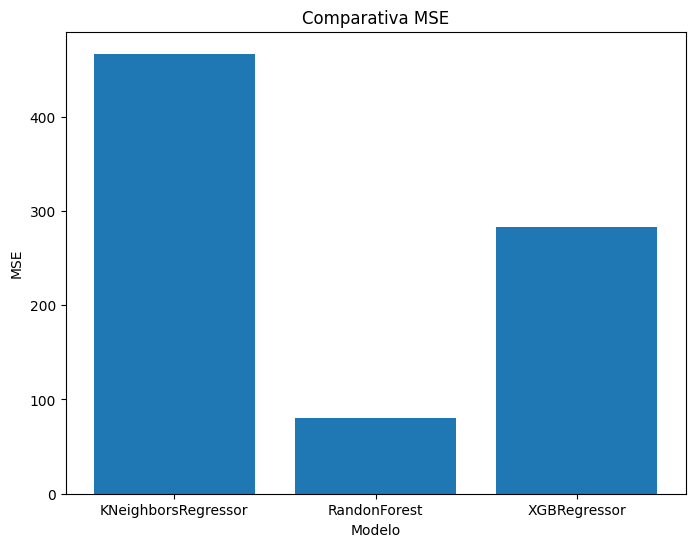

In [132]:
plt.figure(figsize=(8, 6))
plt.bar(list(final_result_tmp.index),final_result_tmp['MSE'])
plt.xlabel('Modelo')
plt.ylabel('MSE')
plt.title('Comparativa MSE')
plt.show()

In [133]:
print(final_result_tmp)

                       MSE     Meals
KNeighborsRegressor  466.6  Pancakes
RandonForest            80   Octopus
XGBRegressor         283.2    Hummus


## Aplicando los modelos a las comidas diarias de una persona

Objetivo: el usuario envia sus datos mediante una API y recibe un json con un listado de alimentos que podria comer durante el dia (tambien se agrega un calculo de cantidad de agua)

In [124]:
def calculate_liquid(age, weight):
    if age <= 30:
        return 40 * weight
    elif age > 30 and age <= 55:
        return 35 * weight
    elif age > 55 and age <= 75:
        return 30 * weight
    else:
        return 25 * weight

In [125]:
meals = ['breakfast', 'dinner','lunch','snack']
nutrient_control = 'Fiber'
age = 37
weight = 75
calories = 1960
nutrient_control = 'Sugar'
result = {}
to_eat_today = []
liquid = round(calculate_liquid(age,weight),2)


for meal in meals:
    df_specific_meal = df_combined[df_combined['Meal'] == meal]
    X = df_specific_meal[features]
    y = df_specific_meal[nutrients]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    constraints_xgbregressor, mse_xgbregressor = get_constraints_from_dataset_xgbregressor(X_train, X_test, y_train, y_test,[[age, weight, calories]])   
    constraints_random_forest, mse_random_forest = get_constraints_from_dataset_random_forest(X_train, X_test, y_train, y_test,[[age, weight, calories]])
    constraints_kn,mse_kn = get_constraints_from_dataset_knr(X_train, X_test, y_train, y_test,[[age, weight, calories]])
    constraints_kn = {key.replace('_meal', ''): value for key, value in constraints_kn.items()}
    constraints_kn = {nutrient: round(value, 2) for nutrient, value in constraints_kn.items()}
    constraints_neural, mse_neural = get_constraints_from_dataset_neural(X_train, X_test, y_train, y_test,[[age, weight, calories]])
    
    meals_dataset_filtered = first_recommendations(df_nutrition_copy, meal)
    
    recomendations_xgbregressor = get_food_recommendations(meals_dataset_filtered,constraints_xgbregressor,nutrient_control)
    recomendations_random_forest = get_food_recommendations(meals_dataset_filtered,constraints_random_forest,nutrient_control)
    recomendations_kn = get_food_recommendations(meals_dataset_filtered,constraints_kn,nutrient_control)
    recomendations_neural = get_food_recommendations(meals_dataset_filtered,constraints_neural,nutrient_control)
    
    to_eat_today.append(recomendations_xgbregressor)
    to_eat_today.append(recomendations_random_forest)
    to_eat_today.append(recomendations_kn)
    to_eat_today.append(recomendations_neural)
    
    result[meal] = {
        'KNeighborsRegressor': {
            'constraints_kn': constraints_kn,
            'recommendations_kn': recomendations_kn,
            'mse': mse_kn
        },
        'Neural': {
            'constraints_neural': constraints_neural,
            'recommendations_neural': recomendations_neural,
            'mse': mse_neural
        },
        'XGBRegressor': {
            'constraints_xgbr': constraints_xgbregressor,
            'recommendations_xgbr': recomendations_xgbregressor,
            'mse': mse_xgbregressor
        },
        'RandomForest': {
            'constraints_random_forest': constraints_random_forest,
            'recommendations_random_forest': recomendations_random_forest,
            'mse': mse_random_forest
        }
    }

1/1 [==============================] - 0s 11ms/step
Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /home/cronopio/Escritorio/TFM - FitBit/TFM_env/lib/python3.10/site-packages/pulp/solverdir/cbc/linux/64/cbc /tmp/d558920b9e144675a3b0ff4f5f57357d-pulp.mps max timeMode elapsed branch printingOptions all solution /tmp/d558920b9e144675a3b0ff4f5f57357d-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 10 COLUMNS
At line 19 RHS
At line 25 BOUNDS
At line 28 ENDATA
Problem MODEL has 5 rows, 2 columns and 5 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 0 - 0.00 seconds
Cgl0004I processed model has 0 rows, 0 columns (0 integer (0 of which binary)) and 0 elements
Cbc3007W No integer variables - nothing to do
Cuts at root node changed objective from 0 to -1.79769e+308
Probing was tried 0 times and created 0 cuts of which 0 were active after adding r

In [126]:
def show_info(result, indent=0):
    for key, value in result.items():
        if isinstance(value, dict):
            print(' ' * indent + f"{key}:")
            show_info(value, indent + 4)
        else:
            print(' ' * indent + f"{key}: {value}")
show_info(result)

breakfast:
    KNeighborsRegressor:
        constraints_kn:
            Proteins: 5.14
            Carbohydrates: 10.28
            Fats: 2.29
            Fiber: 25.0
            Sugar: 25.0
            Calcium: 500.0
            Calories: 452.4
            Vitamin C: 46.96
        recommendations_kn: ['Pancakes']
        mse: 299.18168528571414
    Neural:
        constraints_neural:
            Proteins: 2.200000047683716
            Carbohydrates: 4.179999828338623
            Fats: 3.0199999809265137
            Fiber: 2.809999942779541
            Sugar: 3.0799999237060547
            Calcium: 6.860000133514404
            Calories: 6.170000076293945
            Vitamin C: 1.7699999809265137
        recommendations_neural: ['Pancakes']
        mse: 72399.19141831392
    XGBRegressor:
        constraints_xgbr:
            Proteins: 7.329999923706055
            Carbohydrates: 15.789999961853027
            Fats: 3.299999952316284
            Fiber: 25.0
            Sugar: 25.0
    

In [127]:
print(f"Summary for a person with: Age: {age}, Weight {weight} and Calories: {calories}\n")
print(f"Items to get today:\n")
for item in set(item for sublist in to_eat_today for item in sublist):print(item)
print(f"\nLiquid (ml): {liquid}")

Summary for a person with: Age: 37, Weight 75 and Calories: 1960

Items to get today:

Wheat Flakes
Fruit Cup
Lobster
Currants Black
Hummus
Grapefruit Juice
Oat Bran
Popcorn
Barley
Clams
Pancakes

Liquid (ml): 2625


Esta lista de elementos, puede enviarse por ejemplo:
- A la API de algún supermercado
- A la API de alguna aplicacion de recetas (Cookpad)
- A la API de alguna aplicación de comidas.

Comentarios: La idea es sugerir distinto tipo de alimentos para que una persona decida qué consumir durante el dia. Con un dataset mas grande y con mas detalles del usuario, podriamos filtrar este resultado final en funcion de si el usuario es celíaco, vegetariano, vegano, alérgico a determinados alimentos, etc. Es por eso, que no estamos haciendo una comparacion entre los distintos modelos, lo que necesitamos obtener, es limites razonables que en nigun caso, van a superar los establecidos al inicio del modelo.
De todos modos, los proximos pasos deberian incluir tambien, la selección dinámica del mejor modelo (visto que no siempre el mismo tipo de modelo es el mejor). Sin embargo, dado que el dataset nutricional es pequeño y considerando que el objetivo es crear un menú de opciones, en este caso puntual, mezclamos todos los resultados, eliminamos los alimentos repetidos y le informamos al usuario sus opciones.

Tambien se puede crear un dataframe, adjuntando el valor nutricional de cada elemento seleccionado.

In [129]:
buy = set(item for sublist in to_eat_today for item in sublist)
search_results = df_nutrition_copy[df_nutrition_copy['name'].isin(buy)]
search_results.head(10)

,name,Fiber,Vitamin C,Fats,Proteins,Calories,Sugar,Calcium,Carbohydrates,Category
45,Currants Black,0.0,181.0,3.69,5.6,63,0.0,55,61.52,vegetables
166,Lobster,0.0,0.2,102.00,234.0,143,0.0,60,0.00,seafood
172,Clams,0.0,36.0,1.00,113.0,48,0.0,82,1.00,seafood
188,Wheat Flakes,12.2,0.0,9.00,45.0,360,0.0,18,75.00,cereals
190,Oat Bran,15.4,0.0,6.00,88.0,246,0.8,54,84.00,cereals
191,Barley,17.3,0.0,3.00,35.0,354,0.9,28,154.00,cereals
193,Pancakes,0.6,0.0,6.00,3.4,175,6.5,120,26.00,other
197,Grapefruit Juice,0.2,38.0,0.20,1.6,96,21.2,8,22.20,other
203,Popcorn,15.4,0.0,3.20,7.3,382,0.9,13,78.00,other
205,Hummus,7.9,2.1,8.70,7.9,177,0.2,42,20.20,other
